In [ ]:
!pip install spacy-transformers[cuda100]==0.5.1
!pip install gputil

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 296kB 14.9MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 491kB 19.0MB/s 
     |████████████████████████████████| 341.2MB 53kB/s 
     |████████████████████████████████| 1.1MB 58.4MB/s 
     |████████████████████████████████| 890kB 48.3MB/s 
  Created wheel for spacy-transformers: filename=spacy_transformers-0.5.1-py2.py3-none-any.whl size=52835 sha256=db4684c85849ce9a69cf31c100abb9fef08b5cede142f18e2f4f4567f45aa4ee
  Stored in directory: /root/.cache/pip/wheels/29/c2/17/625a3d14da8cabe9781ab1648d489d1b41a8a81dc289e5af1f
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp36-none-any.whl size=7533 sha256=be7a8c193004dffc36c1b3574a1f7343be5ce27d66e03bd4335b69b5a0d600f5
  Stored in directory: /root/.cache/pip/wheels/06/06/7b/a5f5920bbf4f12a2c927e438fac17d4cd9560f8336b00e9a99
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.

In [ ]:
%tensorflow_version 2.x
import re
import os
import spacy
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import GPUtil
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy.attrs import ORTH, NORM

from keras.preprocessing.text import Tokenizer as KerasTokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding ,LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from google.colab import drive

drive.mount('/content/drive')
__CWDIR__ = pathlib.Path.cwd()
DATASET_DIR = __CWDIR__.joinpath('drive').joinpath('My Drive').joinpath('Colab_Files').joinpath('amazon-product-reviews')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU = tf.device('/device:GPU:0')

is_using_gpu = spacy.prefer_gpu()
if is_using_gpu:
    print("Using GPU!")
    print("GPU Usage")
    GPUtil.showUtilization()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Found GPU at: /device:GPU:0
Using GPU!
GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


In [ ]:
def loadDataHandler(path:str, use_col=None):
    rdata = None
    if use_col and isinstance(use_col, list):
        rdata = pd.read_csv(path, usecols=use_col)
    elif not use_col:
        rdata = pd.read_csv(path)
    return rdata

def barChartsPlot(dict_, title=None):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    type_ = list(dict_.keys())
    values_ = list(dict_.values())
    ax.bar(type_,values_)
    plt.title(title)
    return plt

sample_data_1 = DATASET_DIR.joinpath('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
sample_data_2 = DATASET_DIR.joinpath('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
filter_col = ['reviews.title', 'reviews.text', 'reviews.rating', 'categories', 'primaryCategories']
# filter_col = None
data_1 = loadDataHandler(sample_data_1, use_col=filter_col)
data_2 = loadDataHandler(sample_data_2, use_col=filter_col)
data = pd.concat([data_1, data_2], axis=0).reset_index(drop=True)

In [ ]:
def ratingRelabel(series:pd.Series):
    empty_np = np.zeros(len(series), dtype='<U3')
    for idx, i in enumerate(data['reviews.rating']):
        if i > 3: empty_np[idx] = 'pos'
        elif i == 3: empty_np[idx] = 'neu'
        else: empty_np[idx] = 'neg'
    return empty_np

rating_np = ratingRelabel(data['reviews.rating'])
data = pd.DataFrame(np.column_stack([data, rating_np]))
data.columns = ['categories', 'primary_categories', 'reviews_rating', 'reviews_text', 'reviews_title', 'pos/neg']
data 

,categories,primary_categories,reviews_rating,reviews_text,reviews_title,pos/neg
0,"Computers,Electronics Features,Tablets,Electro...",Electronics,3,I thought it would be as big as small paper bu...,Too small,neu
1,"Computers,Electronics Features,Tablets,Electro...",Electronics,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,pos
2,"Computers,Electronics Features,Tablets,Electro...",Electronics,4,Didnt know how much i'd use a kindle so went f...,Great for the price,pos
3,"Computers,Electronics Features,Tablets,Electro...",Electronics,5,I am 100 happy with my purchase. I caught it o...,A Great Buy,pos
4,"Computers,Electronics Features,Tablets,Electro...",Electronics,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,pos
...,...,...,...,...,...,...
33327,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,5,I got 2 of these for my 8 yr old twins. My 11 ...,Xmas gift,pos
33328,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,4,I bought this for my niece for a Christmas gif...,yes it is a great tablet.,pos
33329,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,5,"Very nice for light internet browsing, keeping...",You get a lot for the price!,pos
33330,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,5,This Tablet does absolutely everything I want!...,You get the entire World for less than $100!,pos


{3: 1403, 5: 23375, 4: 6856, 1: 1028, 2: 670}


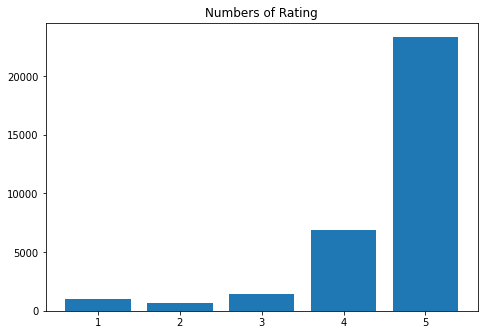

{'neu': 1403, 'pos': 30231, 'neg': 1698}


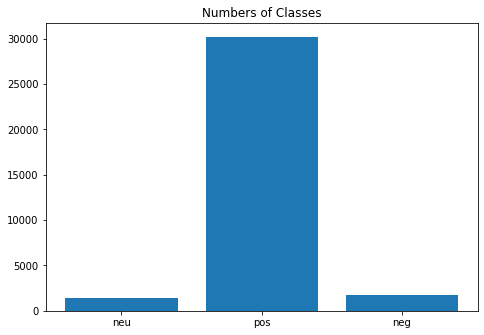

In [ ]:
rating_dict = {}
for i in data['reviews_rating']:
    if i not in rating_dict:
        rating_dict[i] = 0
    rating_dict[i]+=1    
plt = barChartsPlot(rating_dict, title='Numbers of Rating')
print(rating_dict)
plt.show()

classes = {}
for i in data['pos/neg']:
    if i not in classes:
        classes[i] = 0
    classes[i]+=1    
plt = barChartsPlot(classes, title='Numbers of Classes')
print(classes)
plt.show()

In [ ]:
pos_dataset = data.loc[data['pos/neg'] == 'pos']
neu_dataset = data.loc[data['pos/neg'] == 'neu']
neg_dataset = data.loc[data['pos/neg'] == 'neg']
print(f"pos:{len(pos_dataset)}, neu:{len(neu_dataset)}, neg:{len(neg_dataset)}")

pos_dataset = pos_dataset[:3000]
neu_dataset = neu_dataset[:1400]
neg_dataset = neg_dataset[:1600]
dataset = pd.concat([pos_dataset, neu_dataset, neg_dataset], axis=0).reset_index(drop=True)

pos:30231, neu:1403, neg:1698


In [ ]:
dataset

,categories,primary_categories,reviews_rating,reviews_text,reviews_title,pos/neg
0,"Computers,Electronics Features,Tablets,Electro...",Electronics,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,pos
1,"Computers,Electronics Features,Tablets,Electro...",Electronics,4,Didnt know how much i'd use a kindle so went f...,Great for the price,pos
2,"Computers,Electronics Features,Tablets,Electro...",Electronics,5,I am 100 happy with my purchase. I caught it o...,A Great Buy,pos
3,"Computers,Electronics Features,Tablets,Electro...",Electronics,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,pos
4,"Computers,Electronics Features,Tablets,Electro...",Electronics,5,This make an excellent ebook reader. Don't exp...,Good ebook,pos
...,...,...,...,...,...,...
5995,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,1,did not power up...at all. I am so happy that ...,send back,neg
5996,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,2,"After owning the kids Samsung, this seems conf...",so so,neg
5997,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,1,It takes forever to download apps. I'm returni...,Super slow,neg
5998,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,1,"The touch and loading the content is very bad,...",The tablet not so great as mentioned,neg


In [ ]:
x = dataset['reviews_text'].to_list()
y = dataset['pos/neg'].to_list()

In [ ]:
special_case = {
    "couldn't" : [{ORTH: "could"}, {ORTH: "n't", NORM: "not"}],
    "don't" : [{ORTH: "do"}, {ORTH: "n't", NORM: "not"}],
    "wasn't" : [{ORTH: "was"}, {ORTH: "n't", NORM: "not"}],
    "isn't" : [{ORTH: "is"}, {ORTH: "n't", NORM: "not"}],
    "it's" : [{ORTH: "it"}, {ORTH: "'s", NORM: "is"}],
    "wouldn't": [{ORTH: "would"}, {ORTH: "n't", NORM: "not"}],
}
 
class Parser:
    def __init__(self, sent_segmenter=True, custom_tokenize=True):
        spacy.prefer_gpu()
        self.pre_model = spacy.load("en_core_web_sm")
        
        if sent_segmenter:
            self.boundary = re.compile('^[0-9]$')
            self.pre_model.add_pipe(self.custom_seg, before='parser')
        
        if custom_tokenize:
            self.pre_model.tokenizer = self.custom_tokenizer(self.pre_model)
            
            for k,v in special_case.items():
                self.pre_model.tokenizer.add_special_case(k, v)
            
        print(f"Pipe names : {self.pre_model.pipe_names}")
    
    def custom_tokenizer(self, nlp_model):
        infix_re = re.compile(r'''[.\,\?\:\;\...\‘\’\`\“\”\"\'~]''')
        prefix_re = compile_prefix_regex(self.pre_model.Defaults.prefixes)
        suffix_re = compile_suffix_regex(self.pre_model.Defaults.suffixes)
        
        return Tokenizer(self.pre_model.vocab, prefix_search=prefix_re.search,
                                               suffix_search=suffix_re.search,
                                               infix_finditer=infix_re.finditer,
                                               token_match=None)
 
    def custom_seg(self, doc):
        prev = doc[0].text
        length = len(doc)
        for index, token in enumerate(doc):
            if (token.text == '.' and self.boundary.match(prev) and index!=(length - 1)):
                doc[index+1].sent_start = False
            prev = token.text
        return doc
    
    def sent_to_doc(self, sent):
        self.doc = self.pre_model(sent)
    
    def token_normalizer(self, token):
        if(token == "n't"):
            new_token = "not"
        else:
            new_token = token.lower()
        return new_token
    
    def remove_punct(self):
        if 'custom_seg' in self.pre_model.pipe_names:
            rlist = []
            for sent in (self.doc).sents:
                temp_ = []
                for token in sent:
                    if token.pos_ == 'PUNCT':
                        continue
                    new_token = self.token_normalizer(token.text)
                    temp_.append(new_token)
                rlist.append(temp_)
            return rlist
 
parser_obj = Parser(sent_segmenter=True)

Pipe names : ['tagger', 'custom_seg', 'parser', 'ner']


In [ ]:
X_list = []
for idx, review in enumerate(x):
    parser_obj.sent_to_doc(review)
    parsed_list = parser_obj.remove_punct()
    str_ = ""
    for idx_, list_ in enumerate(parsed_list):
        str_ += ' '.join(list_)
        str_ += ' '
    X_list.append(str_)
#     if idx == 100:
#         break

In [ ]:
X = X_list

In [ ]:
tk = KerasTokenizer(lower = True)
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=200, padding='post')
X_pad.shape

(6000, 200)

In [ ]:
onehot = pd.get_dummies(y)
target_labels = onehot.columns
y = onehot.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.25, random_state = 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4500, 200) (1500, 200) (4500, 3) (1500, 3)


In [ ]:
def get_optimizer():
    opt = SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')
    return opt

vocabulary_size = len(tk.word_counts.keys())+1
max_words = 200
embedding_size = 32
batch_size = 64
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
# model.add(LSTM(200, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

with GPU:
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=5, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           205184    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               372800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1203      
Total params: 579,187
Trainable params: 579,187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
71/71 [==============================] - 96s 1s/step - loss: 0.9507 - accuracy: 0.5938 - val_loss: 0.7733 - val_accuracy: 0.6440
Epoch 2/5
71/71 [==============================] - 97s 1s/step - loss: 0.6373 - accuracy: 0.7096 - val_loss: 0.5497 - val_accuracy: 0.7413
Epoch 3/5
71/71 [==============================] - 96s 1s/step - loss: 0.4965 - accuracy: 0.7787 - v

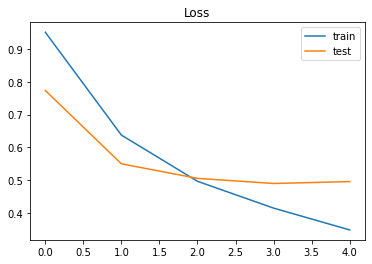

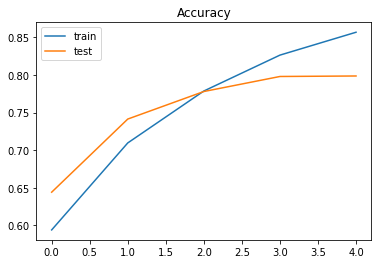

In [ ]:
def validation_acc_loss_plot(model_history):
    plt.title('Loss')
    plt.plot(model_history.history['loss'], label='train')
    plt.plot(model_history.history['val_loss'], label='test')
    plt.legend()
    plt.show();
    plt.title('Accuracy')
    plt.plot(model_history.history['accuracy'], label='train')
    plt.plot(model_history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show();

validation_acc_loss_plot(model_history)

47/47 [==============================] - 4s 86ms/step - loss: 0.4956 - accuracy: 0.7987
Test Score: 0.4955897331237793
Test Accuracy: 0.7986666560173035
              precision    recall  f1-score   support

         neg       0.71      0.78      0.74       363
         neu       0.64      0.58      0.61       377
         pos       0.92      0.92      0.92       760

    accuracy                           0.80      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.80      0.80      0.80      1500



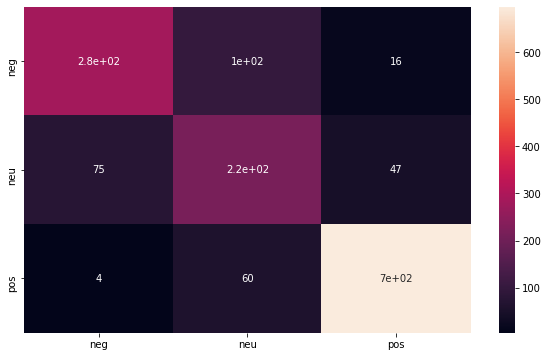

In [ ]:
def plot_confusion_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    index = target_labels
    columns = target_labels
    cm_df = pd.DataFrame(cm,index,columns)                      
    plt.figure(figsize=(10,6))  
    sns.heatmap(cm_df, annot=True)

y_pred = model.predict(X_test)

y_pred = [np.argmax(i) for i in y_pred]
y_test_arr = [np.argmax(j) for j in y_test]

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print(classification_report(y_pred, y_test_arr, target_names=target_labels))
plot_confusion_matrix(y_pred, y_test_arr)
